## Training
Prepapre dataset with the prepare_dataset notebook, before running this one.

In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
from torch.nn import Module, Linear, Conv2d, MaxPool2d, BatchNorm2d, ReLU, Sequential, ConvTranspose2d
from tqdm import tqdm
import scipy.io as sio
from time import time, sleep
import numpy as np
import os
import warnings; warnings.filterwarnings("ignore")
from utils import *
try: 
    JOBID = os.environ["SLURM_JOB_ID"] # get job id from slurm, when training on cluster
    device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu") # nvidia
    HAS_SCREEN = False # for plotting or saving images
except:
    device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu") # apple silicon / cpu
    JOBID = "local"
    HAS_SCREEN = True
os.makedirs(f"mg_data/{JOBID}", exist_ok=True)
print(f'device: {device}')

# copy the python training to the directory (for cluster) (for local, it fails silently)
os.system(f"cp mg_train.py mg_data/{JOBID}/mg_train.py")
os.system(f"cp utils.py mg_data/{JOBID}/utils.py")

def to_tensor(x, device=torch.device("cpu")): return torch.tensor(x, dtype=torch.float32, device=device)

SMALL, NORM, BIG = "small", "norm", "big"

device: cpu


cp: cannot stat 'mg_train.py': No such file or directory


In [8]:
SAVE_DIR = f"mg_data/{JOBID}"  
EPOCHS = 1000 # number of epochs
BATCH_SIZE = 128 # 128 best

# MODEL_NAME = SMALL
# MODEL_NAME = NORM
MODEL_NAME = BIG

LOAD_PRETRAINED = None # Set it to None if you don't want to load pretrained model
# LOAD_PRETRAINED = "trained_models/pretrained_1809761.pth" # norm model
# LOAD_PRETRAINED = "trained_models/pretrained_small_1810888.pth" # small model
# LOAD_PRETRAINED = "trained_models/pretrained_big_1811142.pth" # big model

# LEARNING_RATE = 3e-4*np.linspace(1, 1e-2, EPOCHS)  # best
LEARNING_RATE = 3e-4*np.logspace(0, -2, EPOCHS)
# LEARNING_RATE = 1e-4*np.logspace(0, -2, EPOCHS)

# GSO_LOSS_RATIO = np.linspace(0.4, 0.1, EPOCHS) # best
# GSO_LOSS_RATIO = np.linspace(0.3, 0.1, EPOCHS) # best too
# GSO_LOSS_RATIO = np.linspace(0.4, 0.0, EPOCHS) # best for big model pretrain start
GSO_LOSS_RATIO = np.concatenate((np.linspace(0.4, 0.0, EPOCHS//2), np.linspace(0.0, 0.0, EPOCHS//2))) 
# GSO_LOSS_RATIO = 0.1*np.ones(EPOCHS) # not very good
# GSO_LOSS_RATIO = (0.5+0.5*np.sin(np.linspace(0, 25*np.pi, EPOCHS)))*np.linspace(1, 0.1, EPOCHS) # crazy

#activation functions


USE_CURRENTS = True # usually True
USE_PROFILES = True # false -> more realistic
USE_MAGNETIC = True # usually True

INPUT_SIZE = int(USE_CURRENTS)*14 + int(USE_PROFILES)*202 + int(USE_MAGNETIC)*187
TRAIN_DS_PATH = "dss/train_ds.mat" # generated from prepapre_dataset
EVAL_DS_PATH = "dss/eval_ds.mat"

In [9]:
#checks
assert USE_CURRENTS or USE_PROFILES or USE_MAGNETIC, "At least one of the inputs should be used"
if LOAD_PRETRAINED is not None: assert os.path.exists(LOAD_PRETRAINED), "Pretrained model does not exist"
assert os.path.exists(TRAIN_DS_PATH), "Training dataset does not exist"
assert os.path.exists(EVAL_DS_PATH), "Evaluation dataset does not exist"
assert os.path.exists(SAVE_DIR), "Save directory does not exist"
assert len(LEARNING_RATE) == EPOCHS, "Learning rate array length does not match epochs"
assert len(GSO_LOSS_RATIO) == EPOCHS, "GSO loss ratio array length does not match epochs"

# Best train runs: 
Note: all the metrics are on unseen, mixed (ful grid + subgrid) data. Evaluation on unseen full grid
only is ~ 2x better (MSE halved).
### Old runs with ITER ds
| ID       | NET | MSE    | GS0    | Pre | Notes |
|----------|-----|--------|--------|-----|-------|
| 1810019  | norm | 0.0072 | 0.0730 | / | / |
| 1814867 | big | 0.0012 | **0.0277** | 1811142 | gso .3 -> 0.0, repeat 1814866 |
| 1817333 | big | **0.0009** | 0.0333 | 1811142 | same as 1814866, but keep 0.0 from ep 500-1000 |
| 1959172 | big | **0.0005** | 0.0454 | / | correct swish test, best so far |
### New runs

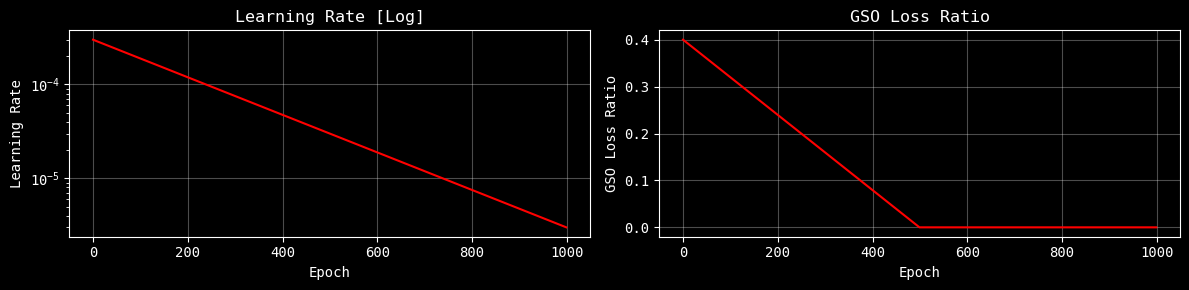

In [10]:
# plot schedulers: lr + gso loss ratio
assert MODEL_NAME in [SMALL, NORM, BIG], f"Model name {MODEL_NAME} not found"
fig, ax = plt.subplots(1, 2, figsize=(12, 3))
ax[0].set_title("Learning Rate [Log]")
ax[0].plot(LEARNING_RATE, color="red")
ax[0].set_xlabel("Epoch")
ax[0].set_ylabel("Learning Rate")
ax[0].set_yscale("log")
ax[1].set_title("GSO Loss Ratio")
ax[1].plot(GSO_LOSS_RATIO, color="red")
ax[1].set_xlabel("Epoch")
ax[1].set_ylabel("GSO Loss Ratio")
plt.tight_layout()
plt.show() if HAS_SCREEN else plt.savefig(f"mg_data/{JOBID}/schedulers.png")

| Measurement    | Mean        | Standard Deviation |
|----------------|-------------|--------------------|
| Current        | -10183.76   | 34209.11           |
| Magnetic       | -0.20       | 0.58               |
| F Profile      | 33.13       | 0.28               |
| P Profile      | 9654.42     | 8788.29            |

In [ ]:
class PlaNetDataset(Dataset):
    def __init__(self, ds_mat_path):
        ds_mat = sio.loadmat(ds_mat_path)
        # output: magnetic flux, transposed (matlab is column-major)
        self.psi = to_tensor(ds_mat["psi"]).view(-1, 1, 64, 64)
        # inputs: radial and vertical position of pixels (for plotting only rn) + currents + measurements + profiles 
        self.rr = to_tensor(ds_mat["rr"]).view(-1,1,64,64) # radial position of pixels (64, 64)
        self.zz = to_tensor(ds_mat["zz"]).view(-1,1,64,64) # vertical position of pixels (64, 64)
        self.currs = ds_mat["currs"] # input currents (n, 14)
        self.magnetic = ds_mat["magnetic"] # input magnetic measurements (n, 187)
        self.profiles = ds_mat["profiles"] # input profiles (n, 101)
        inputs = [] # add the normalized inputs to the list
        if USE_CURRENTS: inputs.append((to_tensor(self.currs)+10183)/34209) # (n, 14) # normalized
        if USE_MAGNETIC: inputs.append((to_tensor(self.magnetic)+0.2)/0.58) # (n, 187) # normalized
        if USE_PROFILES: inputs.append(torch.cat(((to_tensor(self.profiles)-33.13)/0.28, (to_tensor(self.p_profile)-9654)/8788), 1)) # (n, 202) # normalized
        self.inputs = torch.cat(inputs, 1) # (n, 403)
        #move to device (doable bc the dataset is fairly small, check memory usage)
        self.psi, self.inputs, self.rr, self.zz = self.psi.to(device), self.inputs.to(device), self.rr.to(device), self.zz.to(device)
        total_memory = sum([x.element_size()*x.nelement() for x in [self.psi, self.inputs, self.rr, self.zz]])
        print(f"Dataset: {len(self)}, memory: {total_memory/1024**2:.0f} MB")
    def __len__(self): return len(self.psi)
    def __getitem__(self, idx): return self.inputs[idx], self.psi[idx], self.rr[idx], self.zz[idx]

In [12]:
# test dataset
ds = PlaNetDataset(EVAL_DS_PATH)
print(f"Dataset length: {len(ds)}")
print(f"Input shape: {ds[0][0].shape}")
print(f"Output shape: {ds[0][1].shape}")
n_plot = 10
print(len(ds))
fig, axs = plt.subplots(1, n_plot, figsize=(3*n_plot, 5))
for i, j in enumerate(np.random.randint(0, len(ds), n_plot)):
    psi, rr, zz = ds[j][1].cpu().numpy().squeeze(), ds[j][2].cpu().numpy().squeeze(), ds[j][3].cpu().numpy().squeeze()
    axs[i].contourf(rr, zz, psi, 100, cmap="inferno")
    axs[i].contour(rr, zz, -psi, 20, colors="black", linestyles="dotted")
    axs[i].axis("off")
    axs[i].set_aspect("equal")
plt.show() if HAS_SCREEN else plt.savefig(f"mg_data/{JOBID}/dataset.png")

RuntimeError: shape '[-1, 1, 64, 64]' is invalid for input of size 364000

In [ ]:
# activation functions
# custom trainable swish
class Swish(Module):
    def __init__(self, β=1.0): 
        super(Swish, self).__init__()
        # self.β = torch.nn.Parameter(torch.tensor(β, device=device), requires_grad=True)
        self.β = torch.nn.Parameter(torch.tensor(β), requires_grad=True)
    def forward(self, x): 
        return x*torch.sigmoid(self.β*x)
    def to(self, device): 
        self.β = self.β.to(device)
        return super().to(device)

# Λ = ReLU() # ReLU activation function
# Λ = Swish() # Swish activation function

# class Λ(Module): # relu
#     def __init__(self): super(Λ, self).__init__()
#     def forward(self, x): return torch.relu(x)

class Λ(Module): # swish
    def __init__(self): 
        super(Λ, self).__init__()
        self.β = torch.nn.Parameter(torch.tensor(1.0), requires_grad=True)
    def forward(self, x): return x*torch.sigmoid(self.β*x)

In [ ]:
# MODEL: PlaNet: # Paper net: branch + trunk conenction and everything 
if MODEL_NAME == NORM:
    class PlaNet(Module): # Paper net: branch + trunk conenction and everything
        def __init__(self):
            super(PlaNet, self).__init__()
            #branch
            self.branch = Sequential(
                Linear(INPUT_SIZE, 256), Λ(),
                Linear(256, 128), Λ(),
                Linear(128, 64), Λ(),
            )
            #trunk
            # def trunk_block(): # faster
            #     return  Sequential(
            #         Conv2d(1, 8, kernel_size=3, stride=2, padding=1), BatchNorm2d(8), Λ(),
            #         Conv2d(8, 16, kernel_size=3, stride=2, padding=1), BatchNorm2d(16), Λ(),
            #         Conv2d(16, 32, kernel_size=3, stride=2, padding=1), BatchNorm2d(32), Λ(),
            #     )
            def trunk_block(): 
                return  Sequential(
                    Conv2d(1, 8, kernel_size=3, stride=1, padding=1), BatchNorm2d(8), Λ(), MaxPool2d(2),
                    Conv2d(8, 16, kernel_size=3, stride=1, padding=1), BatchNorm2d(16), Λ(), MaxPool2d(2),
                    Conv2d(16, 32, kernel_size=3, stride=1, padding=1), BatchNorm2d(32), Λ(), MaxPool2d(2),
                )
            self.trunk_r, self.trunk_z = trunk_block(), trunk_block()
            self.trunk_fc = Sequential(
                Linear(2*32*8*8, 128), Λ(),
                Linear(128, 64), Λ(),
                Linear(64, 64), Λ(),
            )
            # head
            self.fc = Sequential(Linear(64, 2048), Λ)
            self.anti_conv = Sequential( # U-Net style
                ConvTranspose2d(32, 32, kernel_size=2, stride=2), 
                Conv2d(32, 32, kernel_size=3, padding=0), Λ(),
                Conv2d(32, 32, kernel_size=3, padding=0), Λ(),
                ConvTranspose2d(32, 16, kernel_size=2, stride=2),
                Conv2d(16, 16, kernel_size=3, padding=0), Λ(),
                Conv2d(16, 16, kernel_size=3, padding=0), Λ(),
                ConvTranspose2d(16, 8, kernel_size=2, stride=2),
                Conv2d(8, 8, kernel_size=3, padding=0), Λ(),
                Conv2d(8, 8, kernel_size=3, padding=0), Λ(),
                ConvTranspose2d(8, 4, kernel_size=2, stride=2),
                Conv2d(4, 2, kernel_size=3, padding=0), Λ(),
                Conv2d(2, 1, kernel_size=3, padding=0), Λ(),
                Conv2d(1, 1, kernel_size=5, padding=0),
            )
        def forward(self, x):
            xb, r, z = x
            #branch net
            xb = self.branch(xb)
            #trunk net
            r, z = self.trunk_r(r), self.trunk_z(z) # convolutions
            r, z = r.view(-1, 32*8*8), z.view(-1, 32*8*8) # flatten
            xt = torch.cat((r, z), 1) # concatenate
            xt = self.trunk_fc(xt) # fully connected
            # multiply trunk and branch
            x = xt * xb
            #head net
            x = self.fc(x)
            x = x.view(-1, 32, 8, 8)
            x = self.anti_conv(x)
            return x

In [ ]:
# MODEL: VERY BIG PlaNet: # SAME NET, BUT MORE NEURONS
if MODEL_NAME == BIG:
    class PlaNet(Module): # Paper net: branch + trunk conenction and everything
        def __init__(self):
            super(PlaNet, self).__init__()
            #branch
            self.branch = Sequential(
                Linear(INPUT_SIZE, 256), Λ(),
                Linear(256, 128), Λ(),
                Linear(128, 64), Λ(),
            )
            #trunk
            def trunk_block(): 
                return  Sequential(
                    Conv2d(1, 8, kernel_size=3, stride=1, padding=1), BatchNorm2d(8), Λ(), MaxPool2d(2),
                    Conv2d(8, 16, kernel_size=3, stride=1, padding=1), BatchNorm2d(16), Λ(), MaxPool2d(2),
                    Conv2d(16, 32, kernel_size=3, stride=1, padding=1), BatchNorm2d(32), Λ(), MaxPool2d(2),
                )
            self.trunk_r, self.trunk_z = trunk_block(), trunk_block()
            self.trunk_fc = Sequential(
                Linear(2*32*8*8, 128), Λ(),
                Linear(128, 64), Λ(),
                Linear(64, 64), Λ(), 
            )
            # head
            self.fc = Sequential(Linear(64, 4096), Λ())
            self.anti_conv = Sequential( # U-Net style
                ConvTranspose2d(64, 64, kernel_size=2, stride=2), 
                Conv2d(64, 64, kernel_size=3, padding=0), Λ(),
                Conv2d(64, 64, kernel_size=3, padding=0), Λ(),
                ConvTranspose2d(64, 32, kernel_size=2, stride=2),
                Conv2d(32, 32, kernel_size=3, padding=0), Λ(),
                Conv2d(32, 32, kernel_size=3, padding=0), Λ(),
                ConvTranspose2d(32, 16, kernel_size=2, stride=2),
                Conv2d(16, 16, kernel_size=3, padding=0), Λ(),
                Conv2d(16, 16, kernel_size=3, padding=0), Λ(),
                ConvTranspose2d(16, 8, kernel_size=2, stride=2),
                Conv2d(8, 4, kernel_size=3, padding=0), Λ(),
                Conv2d(4, 2, kernel_size=3, padding=0), Λ(),
                Conv2d(2, 1, kernel_size=5, padding=0),
            )
        def forward(self, x):
            xb, r, z = x
            #branch net
            xb = self.branch(xb)
            #trunk net
            r, z = self.trunk_r(r), self.trunk_z(z) # convolutions
            r, z = r.view(-1, 32*8*8), z.view(-1, 32*8*8) # flatten
            xt = torch.cat((r, z), 1) # concatenate
            xt = self.trunk_fc(xt) # fully connected
            # multiply trunk and branch
            x = xt * xb
            #head net
            x = self.fc(x)
            x = x.view(-1, 64, 8, 8)
            x = self.anti_conv(x)
            return x

In [ ]:
# MODEL: SMALL PlaNet: # Paper net: branch + trunk conenction and everything BUT SMALLER
if MODEL_NAME == SMALL:
    class PlaNet(Module): # Paper net: branch + trunk conenction and everything
        def __init__(self):
            super(PlaNet, self).__init__()
            #branch
            self.branch = Sequential(
                Linear(INPUT_SIZE, 128), Λ(),
                Linear(128, 64), Λ(),
                Linear(64, 32), Λ(),
            )
            def trunk_block(): 
                return  Sequential(
                    Conv2d(1, 4, kernel_size=3, stride=1, padding=1), BatchNorm2d(4), Λ(), MaxPool2d(2),
                    Conv2d(4, 8, kernel_size=3, stride=1, padding=1), BatchNorm2d(8), Λ(), MaxPool2d(2),
                    Conv2d(8, 16, kernel_size=3, stride=1, padding=1), BatchNorm2d(16), Λ(), MaxPool2d(2),
                )
            self.trunk_r, self.trunk_z = trunk_block(), trunk_block()
            self.trunk_fc = Sequential(
                Linear(2*16*8*8, 64), Λ(),
                Linear(64, 32), Λ(),
                Linear(32, 32), Λ(),
            )
            # head
            self.fc = Sequential(Linear(32, 1024), Λ)
            self.anti_conv = Sequential( # U-Net style
                ConvTranspose2d(16, 16, kernel_size=2, stride=2), 
                Conv2d(16, 16, kernel_size=3, padding=0), Λ(),
                Conv2d(16, 16, kernel_size=3, padding=0), Λ(),
                ConvTranspose2d(16, 8, kernel_size=2, stride=2),
                Conv2d(8, 8, kernel_size=3, padding=0), Λ(),
                Conv2d(8, 8, kernel_size=3, padding=0), Λ(),
                ConvTranspose2d(8, 4, kernel_size=2, stride=2),
                Conv2d(4, 4, kernel_size=3, padding=0), Λ(),
                Conv2d(4, 4, kernel_size=3, padding=0), Λ(),
                ConvTranspose2d(4, 2, kernel_size=2, stride=2),
                Conv2d(2, 2, kernel_size=3, padding=0), Λ(),
                Conv2d(2, 1, kernel_size=3, padding=0), Λ(),
                Conv2d(1, 1, kernel_size=5, padding=0),
            )
        def forward(self, x):
            xb, r, z = x
            #branch net
            xb = self.branch(xb)
            #trunk net
            r, z = self.trunk_r(r), self.trunk_z(z) # convolutions
            r, z = r.view(-1, 16*8*8), z.view(-1, 16*8*8) # flatten
            xt = torch.cat((r, z), 1) # concatenate
            xt = self.trunk_fc(xt) # fully connected
            # multiply trunk and branch
            x = xt * xb
            #head net
            x = self.fc(x)
            x = x.view(-1, 16, 8, 8)
            x = self.anti_conv(x)
            return x

In [ ]:
# test model inputs / outputs
x = (torch.rand(1, INPUT_SIZE), torch.rand(1, 1, 64, 64), torch.rand(1, 1, 64, 64))
net = PlaNet()
y = net(x)
print(f"in: {[x.shape for x in x]}, out: {y.shape}")
n_sampl = 7
nx = (torch.rand(n_sampl, INPUT_SIZE), torch.rand(n_sampl, 1, 64, 64), torch.rand(n_sampl, 1, 64, 64))
ny = net(nx)
print(f"in: {[x.shape for x in nx]}, out: {ny.shape}")
assert ny.shape == (n_sampl, 1, 64, 64), f"Wrong output shape: {ny.shape}"

## Training

In [ ]:
def train():
    train_ds, val_ds = PlaNetDataset(TRAIN_DS_PATH), PlaNetDataset(EVAL_DS_PATH) # initialize datasets
    train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True) # initialize DataLoader
    val_dl = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False)  
    model = PlaNet()  # instantiate model
    if LOAD_PRETRAINED is not None: # load pretrained model
        model.load_state_dict(torch.load(LOAD_PRETRAINED, map_location=torch.device("cpu"))) # load pretrained model
        print(f"Pretrained model loaded: {LOAD_PRETRAINED}")
    model.to(device) # move model to device
    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE[0])
    loss_fn = torch.nn.MSELoss() # Mean Squared Error Loss
    tlog_tot, tlog_mse, tlog_gso, elog_tot, elog_mse, elog_gso = [], [], [], [], [], [] # logs for losses
    start_time = time() # start time
    for ep in range(EPOCHS): # epochs
        epoch_time = time()
        for pg in optimizer.param_groups: pg['lr'] = LEARNING_RATE[ep] # update learning rate
        model.train()
        trainloss, evalloss = [], []
        for input, psi, rr, zz in train_dl:
            optimizer.zero_grad() # zero gradients
            psi_pred = model((input, rr, zz)) # forward pass
            gso, gso_pred = calc_gso_batch(psi, rr, zz, dev=device), calc_gso_batch(psi_pred, rr, zz, dev=device) # calculate grad shafranov
            mse_loss = loss_fn(psi_pred, psi) # mean squared error loss on psi
            gso_loss = loss_fn(gso_pred, gso) # PINN loss on grad shafranov
            loss = (1-GSO_LOSS_RATIO[ep])*mse_loss + GSO_LOSS_RATIO[ep]*gso_loss # total loss
            loss.backward() # backprop
            optimizer.step() # update weights
            trainloss.append((loss.item(), mse_loss.item(), gso_loss.item())) # save batch losses
        model.eval() # evaluation mode
        with torch.no_grad():
            for input, psi, rr, zz in val_dl:
                psi_pred = model((input, rr, zz))
                gso, gso_pred = calc_gso_batch(psi, rr, zz, dev=device), calc_gso_batch(psi_pred, rr, zz, dev=device)
                mse_loss = loss_fn(psi_pred, psi)
                gso_loss = loss_fn(gso_pred, gso)
                loss = (1-GSO_LOSS_RATIO[ep])*mse_loss + GSO_LOSS_RATIO[ep]*gso_loss # total loss
                evalloss.append((loss.item(), mse_loss.item(), gso_loss.item()))
        tloss_tot, tloss_mse, tloss_gso = map(lambda x: sum(x)/len(x), zip(*trainloss))
        eloss_tot, eloss_mse, eloss_gso = map(lambda x: sum(x)/len(x), zip(*evalloss))
        # save model if improved        
        endp = "\n" 
        if eloss_tot <= min(elog_tot, default=eloss_tot): 
            torch.save(model.state_dict(), f"{SAVE_DIR}/mg_planet_tot.pth"); endp=" *tot\n"
        if eloss_mse <= min(elog_mse, default=eloss_mse):
            torch.save(model.state_dict(), f"{SAVE_DIR}/mg_planet_mse.pth"); endp=" *mse\n"
        if eloss_gso <= min(elog_gso, default=eloss_gso):
            torch.save(model.state_dict(), f"{SAVE_DIR}/mg_planet_gso.pth"); endp=" *gso\n"
        tlog_tot.append(tloss_tot); tlog_mse.append(tloss_mse); tlog_gso.append(tloss_gso)
        elog_tot.append(eloss_tot); elog_mse.append(eloss_mse); elog_gso.append(eloss_gso) 
        print(f"{ep+1}/{EPOCHS}: "
            f"Eval: tot {eloss_tot:.4f}, mse {eloss_mse:.4f}, gso {eloss_gso:.4f} | " + 
            f"lr:{LEARNING_RATE[ep]:.1e}, r:{GSO_LOSS_RATIO[ep]:.2f} | {time()-epoch_time:.0f}s, eta:{(time()-start_time)*(EPOCHS-ep)/(ep+1)/60:.0f}m |", end=endp,  flush=True)
        if ep >= 10 and ((eloss_gso > 30.0 and GSO_LOSS_RATIO[ep] > 0.01) or eloss_mse > 11.0): return False, () # stop training, if not converging, try again
    print(f"Training time: {(time()-start_time)/60:.0f}mins")
    print(f"Best losses: tot {min(elog_tot):.4f}, mse {min(elog_mse):.4f}, gso {min(elog_gso):.4f}")
    for l, n in zip([tlog_tot, tlog_mse, tlog_gso], ["tot", "mse", "gso"]): np.save(f"{SAVE_DIR}/train_{n}_losses.npy", l) # save losses
    for l, n in zip([elog_tot, elog_mse, elog_gso], ["tot", "mse", "gso"]): np.save(f"{SAVE_DIR}/eval_{n}_losses.npy", l) # save losses
    return True, (tlog_tot, tlog_mse, tlog_gso, elog_tot, elog_mse, elog_gso)

# train the model (multiple attempts)
for i in range(10): 
    success, logs = train()
    if success: tlog_tot, tlog_mse, tlog_gso, elog_tot, elog_mse, elog_gso = logs; break
    else: print(f"Convergence failed, retrying... {i+1}/10")
assert success, "Training failed"

In [ ]:
# plot losses
fig, ax = plt.subplots(2, 3, figsize=(12, 6))
ce, ct = "yellow", "red"
lw = 1.0
ax[0,0].set_title("TOT Loss")
ax[0,0].plot(tlog_tot, color=ct, label="train", linewidth=lw)
ax[0,0].plot(elog_tot, color=ce, label="eval", linewidth=lw)
ax[0,1].set_title("MSE Loss")
ax[0,1].plot(tlog_mse, color=ct, label="train", linewidth=lw)
ax[0,1].plot(elog_mse, color=ce, label="eval", linewidth=lw)
ax[0,2].set_title("GSO Loss")
ax[0,2].plot(tlog_gso, color=ct, label="train", linewidth=lw)
ax[0,2].plot(elog_gso, color=ce, label="eval", linewidth=lw)
#now the same but with log scale
ax[1,0].set_title("TOT Loss (log)")
ax[1,0].plot(tlog_tot, color=ct, label="train", linewidth=lw)
ax[1,0].plot(elog_tot, color=ce, label="eval", linewidth=lw)
ax[1,0].set_yscale("log")
ax[1,0].grid(True, which="both", axis="y")

ax[1,1].set_title("MSE Loss (log)")
ax[1,1].plot(tlog_mse, color=ct, label="train", linewidth=lw)
ax[1,1].plot(elog_mse, color=ce, label="eval", linewidth=lw)
ax[1,1].set_yscale("log")
ax[1,1].grid(True, which="both", axis="y")

ax[1,2].set_title("GSO Loss (log)")
ax[1,2].plot(tlog_gso, color=ct, label="train", linewidth=lw)
ax[1,2].plot(elog_gso, color=ce, label="eval", linewidth=lw)
ax[1,2].set_yscale("log")
ax[1,2].grid(True, which="both", axis="y")
for a in ax.flatten(): a.legend(); a.set_xlabel("Epoch"); a.set_ylabel("Loss")
plt.tight_layout()
plt.show() if HAS_SCREEN else plt.savefig(f"mg_data/{JOBID}/losses.png")

In [ ]:
# testing network output
for titl, best_model_path in zip(["TOT","MSE", "GSO"], ["mg_planet_tot.pth", "mg_planet_mse.pth", "mg_planet_gso.pth"]):
    model = PlaNet()
    model.load_state_dict(torch.load(f"{SAVE_DIR}/{best_model_path}"))
    model.eval()
    ds = PlaNetDataset(EVAL_DS_PATH)
    # ds = PlaNetDataset(TRAIN_DS_PATH)
    os.makedirs(f"mg_data/{JOBID}/imgs", exist_ok=True)
    N_PLOTS = 2 if HAS_SCREEN else 50
    for i in np.random.randint(0, len(ds), N_PLOTS):  
        fig, axs = plt.subplots(2, 5, figsize=(15, 9))
        input, psi_ds, rr, zz = ds[i]
        input, psi_ds, rr, zz = input.to('cpu'), psi_ds.to('cpu'), rr.to('cpu'), zz.to('cpu')
        input, psi_ds, rr, zz = input.view(1,-1), psi_ds.view(1,1,64,64), rr.view(1,1,64,64), zz.view(1,1,64,64)
        psi_pred = model((input, rr, zz))
        gso, gso_pred = calc_gso_batch(psi_ds, rr, zz), calc_gso_batch(psi_pred, rr, zz)
        gso, gso_pred = gso.detach().numpy().reshape(64, 64), gso_pred.detach().numpy().reshape(64, 64)
        gso_range = (gso.max(), gso.min())
        gso_levels = np.linspace(gso_range[1], gso_range[0], 12)
        gso_pred = np.clip(gso_pred, gso_range[1], gso_range[0]) # clip to gso range
        
        psi_pred = psi_pred.detach().numpy().reshape(64, 64)
        psi_ds = psi_ds.detach().numpy().reshape(64, 64)
        rr, zz = rr.view(64, 64).detach().numpy(), zz.view(64, 64).detach().numpy()
        ext = [ds.rr.min(), ds.rr.max(), ds.zz.min(), ds.zz.max()]
        bmin, bmax = np.min([psi_ds, psi_pred]), np.max([psi_ds, psi_pred]) # min max psi
        blevels = np.linspace(bmin, bmax, 13, endpoint=True)
        ψ_mse = (psi_ds - psi_pred)**2
        gso_mse = (gso - gso_pred)**2
        mse_levels1 = np.linspace(0, 0.5, 13, endpoint=True)
        mse_levels2 = np.linspace(0, 0.05, 13, endpoint=True)

        im00 = axs[0,0].contourf(rr, zz, psi_ds, blevels, cmap="inferno")
        axs[0,0].set_title("Actual")
        axs[0,0].set_aspect('equal')
        axs[0,0].set_ylabel("ψ")
        fig.colorbar(im00, ax=axs[0,0]) 
        im01 = axs[0,1].contourf(rr, zz, psi_pred, blevels, cmap="inferno")
        axs[0,1].set_title("Predicted")
        fig.colorbar(im01, ax=axs[0,1])
        im02 = axs[0,2].contour(rr, zz, psi_ds, blevels, linestyles='dashed', cmap="inferno")
        axs[0,2].contour(rr, zz, psi_pred, blevels, cmap="inferno")
        axs[0,2].set_title("Contours")
        fig.colorbar(im02, ax=axs[0,2])
        im03 = axs[0,3].contourf(rr, zz, np.clip(ψ_mse, 0, 0.5), mse_levels1, cmap="inferno")
        axs[0,3].set_title("MSE 0.5")
        fig.colorbar(im03, ax=axs[0,3])
        im04 = axs[0,4].contourf(rr, zz, np.clip(ψ_mse, 0.00001, 0.04999), mse_levels2, cmap="inferno")
        axs[0,4].set_title("MSE 0.05")
        fig.colorbar(im04, ax=axs[0,4])
        im10 = axs[1,0].contourf(rr, zz, gso, gso_levels, cmap="inferno")
        axs[1,0].set_ylabel("GSO")
        fig.colorbar(im10, ax=axs[1,0])
        im6 = axs[1,1].contourf(rr, zz, gso_pred, gso_levels, cmap="inferno")
        fig.colorbar(im6, ax=axs[1,1])
        im12 = axs[1,2].contour(rr, zz, gso, gso_levels, linestyles='dashed', cmap="inferno")
        axs[1,2].contour(rr, zz, gso_pred, gso_levels, cmap="inferno")
        fig.colorbar(im12, ax=axs[1,2])
        im13 = axs[1,3].contourf(rr, zz, np.clip(gso_mse, 0, 0.5), mse_levels1, cmap="inferno")
        fig.colorbar(im13, ax=axs[1,3])
        im14 = axs[1,4].contourf(rr, zz, np.clip(gso_mse, 0.00001, 0.04999), mse_levels2, cmap="inferno")
        fig.colorbar(im14, ax=axs[1,4])

        for ax in axs.flatten(): ax.grid(False), ax.set_xticks([]), ax.set_yticks([]), ax.set_aspect("equal")

        #suptitle
        plt.suptitle(f"PlaNet: {titl} {i}")

        plt.tight_layout()
        plt.show() if HAS_SCREEN else plt.savefig(f"mg_data/{JOBID}/imgs/planet_{titl}_{i}.png")
        plt.close()

In [ ]:
# test inference speed
model = PlaNet()
model.load_state_dict(torch.load(f"{SAVE_DIR}/{best_model_path}"))
model.eval()
ds = PlaNetDataset(EVAL_DS_PATH)
n_samples = 100
random_idxs = np.random.choice(n_samples, len(ds))
#cpu
cpu_times = []
for i in random_idxs:
    start_t = time()
    input, psi_ds, rr, zz = ds[i]
    input, psi_ds, rr, zz = input.to('cpu'), psi_ds.to('cpu'), rr.to('cpu'), zz.to('cpu')
    input, psi_ds, rr, zz = input.view(1,-1), psi_ds.view(1,1,64,64), rr.view(1,1,64,64), zz.view(1,1,64,64)
    psi_pred = model((input, rr, zz))
    end_t = time()
    cpu_times.append(end_t - start_t) 
# device
model.to(device)
dev_times = []
for i in random_idxs:
    input, psi_ds, rr, zz = ds[i]
    input, psi_ds, rr, zz = input.view(1,-1), psi_ds.view(1,1,64,64), rr.view(1,1,64,64), zz.view(1,1,64,64)
    start_t = time()
    psi_pred = model((input, rr, zz))
    end_t = time()
    dev_times.append(end_t - start_t)    
cpu_times, dev_times = np.array(cpu_times), np.array(dev_times)
print(f"cpu: inference time: {cpu_times.mean():.5f}s, std: {cpu_times.std():.5f}")
print(f"dev: inference time: {dev_times.mean():.5f}s, std: {dev_times.std():.5f}")

In [ ]:
print("Done", flush=True)
if not HAS_SCREEN: sleep(30) # wait for files to update (for cluster)

In [ ]:
#copy the log file to the folder
os.system(f"cp jobs/{JOBID}.txt mg_data/{JOBID}/log.txt")

In [ ]:
if not HAS_SCREEN: exit(0) # skip this test sections on cluster
# testing network output on full frame dataset (not subgrids)
TESTS_DIR = "mg_data_deicluster/1817333"
for titl, best_model_path in zip(["TOT","MSE", "GSO"], ["mg_planet_tot.pth", "mg_planet_mse.pth", "mg_planet_gso.pth"]):
    model = PlaNet()
    model.load_state_dict(torch.load(f"{TESTS_DIR}/{best_model_path}", map_location=torch.device("cpu")))
    model.to(device)
    model.eval()

    # ds = PlaNetDataset("data/train_ds_10000_80_100.mat")
    ds = PlaNetDataset("data/eval_ds_10000_80_100.mat")

    #run an evaluation on all the dataset
    dl = DataLoader(ds, batch_size=1000, shuffle=False)
    mses, gsos = [],[]
    for input, psi_ds, rr, zz in dl:
        psi_pred = model((input, rr, zz))
        gso, gso_pred = calc_gso_batch(psi_ds, rr, zz, device), calc_gso_batch(psi_pred, rr, zz, device)
        loss_gso = torch.nn.MSELoss()(gso, gso_pred)
        loss_psi = torch.nn.MSELoss()(psi_ds, psi_pred)
        mses.append(loss_psi.item())
        gsos.append(loss_gso.item())
    print(f"Model {titl} MSE: {np.mean(mses):.5f}, GSO: {np.mean(gsos):.5f}")

    os.makedirs(f"mg_data/{JOBID}/imgs", exist_ok=True)
    N_PLOTS = 2 if HAS_SCREEN else 50
    model.to('cpu')
    for i in np.random.randint(0, len(ds), N_PLOTS):  
        fig, axs = plt.subplots(2, 5, figsize=(15, 9))
        input, psi_ds, rr, zz = ds[i]
        input, psi_ds, rr, zz = input.to('cpu'), psi_ds.to('cpu'), rr.to('cpu'), zz.to('cpu')
        input, psi_ds, rr, zz = input.view(1,-1), psi_ds.view(1,1,64,64), rr.view(1,1,64,64), zz.view(1,1,64,64)
        psi_pred = model((input, rr, zz))
        gso, gso_pred = calc_gso_batch(psi_ds, rr, zz), calc_gso_batch(psi_pred, rr, zz)
        gso, gso_pred = gso.detach().numpy().reshape(64, 64), gso_pred.detach().numpy().reshape(64, 64)
        gso_range = (gso.max(), gso.min())
        gso_levels = np.linspace(gso_range[1], gso_range[0], 12)
        gso_pred = np.clip(gso_pred, gso_range[1], gso_range[0]) # clip to gso range
        
        psi_pred = psi_pred.detach().numpy().reshape(64, 64)
        psi_ds = psi_ds.detach().numpy().reshape(64, 64)
        rr, zz = rr.view(64, 64).detach().numpy(), zz.view(64, 64).detach().numpy()
        ext = [ds.rr.min(), ds.rr.max(), ds.zz.min(), ds.zz.max()]
        bmin, bmax = np.min([psi_ds, psi_pred]), np.max([psi_ds, psi_pred]) # min max psi
        blevels = np.linspace(bmin, bmax, 13, endpoint=True)
        ψ_mse = (psi_ds - psi_pred)**2
        gso_mse = (gso - gso_pred)**2
        mse_levels1 = np.linspace(0, 0.5, 13, endpoint=True)
        mse_levels2 = np.linspace(0, 0.05, 13, endpoint=True)

        im00 = axs[0,0].contourf(rr, zz, psi_ds, blevels, cmap="inferno")
        axs[0,0].set_title("Actual")
        axs[0,0].set_aspect('equal')
        axs[0,0].set_ylabel("ψ")
        fig.colorbar(im00, ax=axs[0,0]) 
        im01 = axs[0,1].contourf(rr, zz, psi_pred, blevels, cmap="inferno")
        axs[0,1].set_title("Predicted")
        fig.colorbar(im01, ax=axs[0,1])
        im02 = axs[0,2].contour(rr, zz, psi_ds, blevels, linestyles='dashed', cmap="inferno")
        axs[0,2].contour(rr, zz, psi_pred, blevels, cmap="inferno")
        axs[0,2].set_title("Contours")
        fig.colorbar(im02, ax=axs[0,2])
        im03 = axs[0,3].contourf(rr, zz, np.clip(ψ_mse, 0, 0.5), mse_levels1, cmap="inferno")
        axs[0,3].set_title("MSE 0.5")
        fig.colorbar(im03, ax=axs[0,3])
        im04 = axs[0,4].contourf(rr, zz, np.clip(ψ_mse, 0.00001, 0.04999), mse_levels2, cmap="inferno")
        axs[0,4].set_title("MSE 0.05")
        fig.colorbar(im04, ax=axs[0,4])
        im10 = axs[1,0].contourf(rr, zz, gso, gso_levels, cmap="inferno")
        axs[1,0].set_ylabel("GSO")
        fig.colorbar(im10, ax=axs[1,0])
        im6 = axs[1,1].contourf(rr, zz, gso_pred, gso_levels, cmap="inferno")
        fig.colorbar(im6, ax=axs[1,1])
        im12 = axs[1,2].contour(rr, zz, gso, gso_levels, linestyles='dashed', cmap="inferno")
        axs[1,2].contour(rr, zz, gso_pred, gso_levels, cmap="inferno")
        fig.colorbar(im12, ax=axs[1,2])
        im13 = axs[1,3].contourf(rr, zz, np.clip(gso_mse, 0, 0.5), mse_levels1, cmap="inferno")
        fig.colorbar(im13, ax=axs[1,3])
        im14 = axs[1,4].contourf(rr, zz, np.clip(gso_mse, 0.00001, 0.04999), mse_levels2, cmap="inferno")
        fig.colorbar(im14, ax=axs[1,4])

        for ax in axs.flatten(): ax.grid(False), ax.set_xticks([]), ax.set_yticks([]), ax.set_aspect("equal")

        #suptitle
        plt.suptitle(f"PlaNet: {titl} {i}")

        plt.tight_layout()
        plt.show() if HAS_SCREEN else plt.savefig(f"mg_data/{JOBID}/imgs/planet_{titl}_{i}.png")
        plt.close()